# TSSL Lab 3 - Nonlinear state space models and Sequential Monte Carlo
In this lab we will make use of a non-linear state space model for analyzing the dynamics of SARS-CoV-2, the virus causing covid-19. We will use an epidemiological model referred to as a Susceptible-Exposed-Infectious-Recovered (SEIR) model. It is a stochastic adaptation of the model used by the The Public Health Agency of Sweden for predicting the spread of covid-19 in the Stockholm region early in the pandemic, see [Estimates of the peak-day and the number of infected individuals during the covid-19 outbreak in the Stockholm region, Sweden February – April 2020](https://www.folkhalsomyndigheten.se/publicerat-material/publikationsarkiv/e/estimates-of-the-peak-day-and-the-number-of-infected-individuals-during-the-covid-19-outbreak-in-the-stockholm-region-sweden-february--april-2020/).

The background and details of the SEIR model that we will use are available in the document _TSSL Lab 3 Predicting Covid-19 Description of the SEIR model_ on LISAM. Please read through the model description before starting on the lab assignments to get a feeling for what type of model that we will work with.

---

### DISCLAIMER
Even though we will use a type of model that is common in epidemiological studies and analyze real covid-19 data, you should _NOT_ read to much into the results of the lab. The model is intentionally simplified to fit the scope of the lab, it is not validated, and it involves several model parameters that are set somewhat arbitrarily. The lab is intended to be an illustration of how we can work with nonlinear state space models and Sequential Monte Carlo methods to solve a problem of practical interest, but the actual predictions made by the final model should be taken with a big grain of salt.

---


We load a few packages that are useful for solving this lab assignment.

In [1]:
import pandas  # Loading data / handling data frames
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)  # Increase default size of plots

## 3.1 A first glance at the data
The data that we will use in this lab is a time series consisting of daily covid-19-related intensive care cases in Stockholm from March 2020 to March 2021. As always, we start by loading and plotting the data.

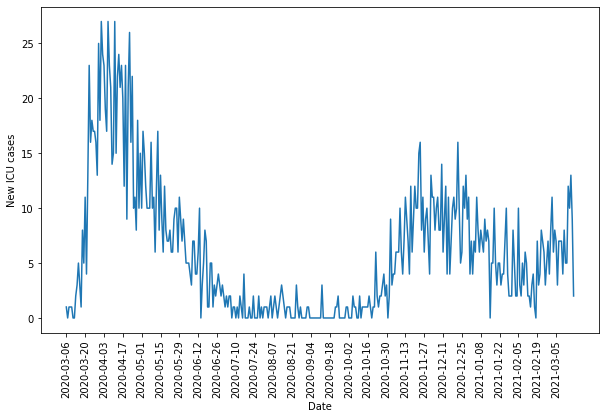

In [2]:
data=pandas.read_csv('SIR_Stockholm.csv',header=0)
y_sthlm = data['ICU'].values
u_sthlm = data['Date'].values
ndata = len(y_sthlm)
plt.plot(u_sthlm,y_sthlm)
plt.xticks(range(0, ndata, 14), u_sthlm[::14], rotation = 90)  # Show only one tick per 2 week for clarity
plt.xlabel('Date')
plt.ylabel('New ICU cases')
plt.show()

**Q0:** What type of values can the observations $y_t$ take? Is a Gaussian likelihood model a good choice if we want to respect the properties of the data?

**A:** natural numbers. Gaussian likelihhod model can take real numbers, so its not a best choise 

## 3.2 Setting up and simulating the SEIR model
In this section we will set up a SEIR model and use this to simulate a synthetic data set. You should keep these simulated trajectories, we will use them in the following sections.

In [3]:
from tssltools_lab3 import Param, SEIR

"""For Stockholm the population is probably roughly 2.5 million."""
population_size = 2500000  

"""" Binomial probabilities (p_se, p_ei, p_ir, and p_ic) and the transmission rate (rho)"""
pse = 0        # This controls the rate of spontaneous s->e transitions. It is set to zero for this lab.
pei = 1 / 5.1  # Based on FHM report
pir = 1 / 5    # Based on FHM report
pic = 1 / 1000 # Quite arbitrary!
rho = 0.3      # Quite arbitrary!

""" The instantaneous contact rate b[t] is modeled as
  b[t] = exp(z[t])
  z[t] = z[t-1] + epsilon[t], epsilon[t] ~ N(0,sigma_epsilon^2)
"""
sigma_epsilon = .1

""" For setting the initial state of the simulation"""
i0 = 1000  # Mean number of infectious individuals at initial time point
e0 = 5000  # Mean number of exposed...
r0 = 0     # Mean number of recovered
s0 = population_size - i0 - e0 - r0  # Mean number of susceptible
init_mean = np.array([s0, e0, i0, 0.], dtype=np.float64)  # The last 0. is the mean of z[0]

"""All the above parameters are stored in params."""
params = Param(pse, pei, pir, pic, rho, sigma_epsilon, init_mean, population_size)

""" Create a model instance"""
model = SEIR(params)

**Q1:** Generate $10$ different trajectories of length $200$ from the model an plot them in one figure. Does the trajectories look reasonable? Could the data have been generated using this model? 

For reproducability, we set the seed of the random number generator to 0 before simulating the trajectories using np.random.seed(0)

Save these $10$ generated trajectories for future use.

*(hint: The SEIR class has a simulate method)*

In [4]:
np.random.seed(0)
alpha, y = model.simulate(200,10)

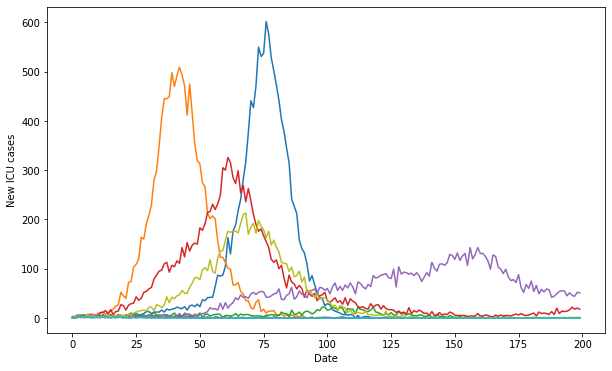

In [5]:
for i in range(10):
    plt.plot(np.arange(200),y[0,i,:])
plt.xlabel('Date')
plt.ylabel('New ICU cases')
plt.show()

 
trajectories look not reasonable because, after increase of new icu cases where will be a drop, as we assume people cant be sick twice. But we know that in reality its not a true.

## 3.3 Sequential Importance Sampling

Next, we pick out one trajectory that we will use for filtering. We use simulated data to start with, since we then know the true underlying SEIR states and can compare the filter results with the ground truth.

**Q2:** Implement the **Sequential Importance Sampling** algorithm by filling in the following functions.

The **exp_norm** function should return the normalized weights and the log average of the unnormalized weights.
For numerical reasons, when calculating the weights we should "normalize" the log-weights first by removing the maximal value.

Let $\bar{\omega}_t = \max(\log \omega_t^i)$ and take the exponential of $\log \tilde{\omega}_t^i = \log \omega_t^i - \bar{\omega}_t$. Normalizing $\tilde{\omega}_t^i$ will yield the normalized weights!

For the log average of the unnormalized weights, care has to be taken to get the correct output,
$\log (1/N \sum_{i=1}^{N} \tilde{\omega}_t^i) = \log( 1/N \sum_{i=1}^{N} \omega_t^i) - \bar{\omega}_t$.
We are going to need this in the future, so best to implement it right away.

*(hint: look at the SEIR model class, it contains all necessary functions for propagation and weighting)*

In [6]:
from tssltools_lab3 import smc_res

def exp_norm(logwgt):
    """
    Exponentiates and normalizes the log-weights.
    
    Parameters
    ----------
    logwgt : ndarray
        Array of size (N,) with log-weights.
    
    Returns
    -------
    wgt : ndarray
        Array of size (N,) with normalized weights, wgt[i] = exp(logwgt[i])/sum(exp(logwgt)),
        but computed in a /numerically robust way/!
    logZ : float
        log of the normalizing constant, logZ = log(sum(exp(logwgt))),
        but computed in a /numerically robust way/!
    """        
    wt_bar = max(logwgt)
    logwt_tilde = logwgt - wt_bar
    wgt = np.exp(logwt_tilde) / (np.exp(logwt_tilde).sum())
    
    # log weight should be normalised or not here? not normalised 
    logZ = np.log(np.exp(logwt_tilde).sum()) + wt_bar - np.log(len(wgt))
    
    return wgt, logZ

def ESS(wgt):
    """
    Computes the effective sample size.
    
    Parameters
    ----------
    wgt : ndarray
        Array of size (N,) with normalized importance weights.
    
    Returns
    -------
    ess : float
        Effective sample size.
    """         
    ess = (wgt.sum()**2) / ((wgt**2).sum()) 
    return ess

def sis_filter(model, y, N):
    d = model.d
    n = len(y)
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:
            particles[:, :, 0] = model.sample_state(N=N) # Initialize from p(alpha_1)
            
            # should this be log? 
            logW[0, :, 0] = model.log_lik(y[t], particles[:, :, 0]) # Compute weights this comes from likelihood and should be log 
        else:
            particles[:, :, t] = model.sample_state(alpha0=particles[:, :, (t-1)], N=N) # Propagate according to dynamics
            
            # why its likelihood? 
            logW[0, :, t] = model.log_lik(y[t], particles[:, :, t]) + logW[0, :, (t-1)] # should the weights be normalised?  

        # Normalize the importance weights and compute N_eff
        W[0, :, t], _ = exp_norm(logW[0, :, t])
        N_eff[t] = ESS(W[0,:,t])

        # Compute filter estimates
        
        alpha_filt[:, 0, t] =   particles[:, :, t] @ W[0, :, t]
        
    return smc_res(alpha_filt, particles, W, logW=logW, N_eff=N_eff)

**Q3:** Choose one of the simulated trajectories and run the SIS algorithm using $N = 100$ particles. Show plots comparing the filter means from the SIS algorithm with the underlying truth of the Infected, Exposed and Recovered. 

Also show a plot of how the ESS behaves over the run. 

*(hint: In the model we use the S, E, I as states, but S will be much larger than the others. To calculate R, note that S + E + I + R = Population)*

In [7]:
sis_alphas = sis_filter(model, y[0, 0,:], 100).alpha_filt
sis_ESS = sis_filter(model, y[0, 0,:], 100).N_eff
sis_logW = sis_filter(model, y[0, 0,:], 100).logW

In [8]:
sis_logW[:,:,199]

array([[-25169.3518694 , -33795.81537817, -32428.30874845,
        -65315.37442908, -35628.14500835,            -inf,
          -931.55007505,            -inf,            -inf,
                   -inf,            -inf,            -inf,
                   -inf,            -inf,   -761.98351314,
                   -inf,            -inf,            -inf,
        -18932.72727204,            -inf,            -inf,
        -10211.65502672,            -inf, -15367.14581452,
         -5237.90972896, -10161.40427233, -16479.13059319,
                   -inf, -54133.0687798 ,            -inf,
                   -inf,            -inf,  -7176.1416305 ,
                   -inf, -12851.96726272,            -inf,
        -42057.61754704, -47460.06041618, -48487.83816233,
        -39295.39956234,  -4916.57429975,            -inf,
        -45317.36602124,            -inf, -66315.8061945 ,
         -1910.54386082,            -inf,            -inf,
        -23788.54311205,            -inf,            -in

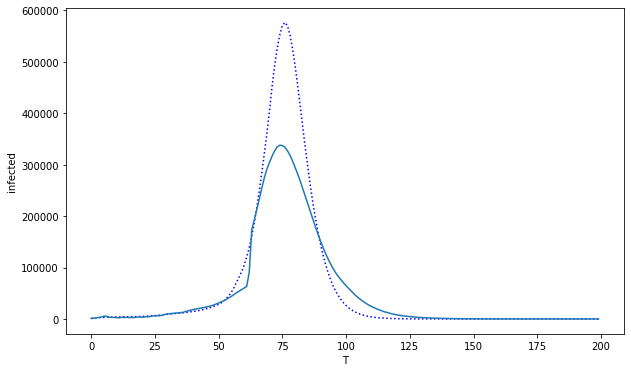

In [9]:
# infected 

plt.plot(np.arange(200),alpha[2,0,:], "b:")
plt.plot(np.arange(200),sis_alphas[2,0,:])
plt.xlabel('T')
plt.ylabel('infected')
plt.show()

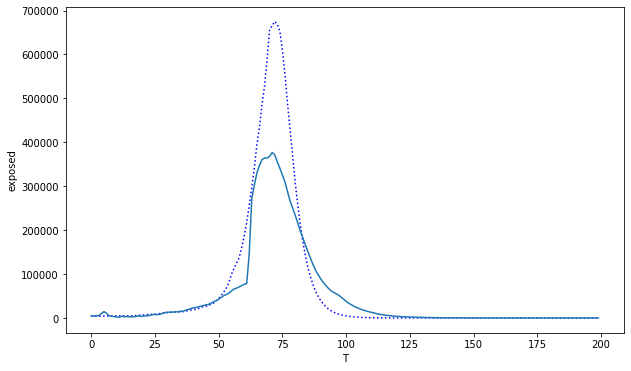

In [10]:
# exposed

plt.plot(np.arange(200),alpha[1,0,:], "b:")
plt.plot(np.arange(200),sis_alphas[1,0,:])
plt.xlabel('T')
plt.ylabel('exposed')
plt.show()

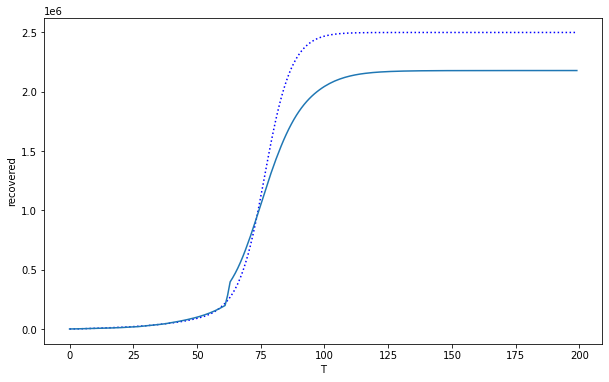

In [11]:
# recovered
R_sample = population_size - alpha[0,0,:] - alpha[1,0,:] - alpha[2,0,:] 
R_filter = population_size - sis_alphas[0,0,:] - sis_alphas[1,0,:] - sis_alphas[2,0,:] 
plt.plot(np.arange(200), R_sample, "b:")
plt.plot(np.arange(200), R_filter)
plt.xlabel('T')
plt.ylabel('recovered')
plt.show()

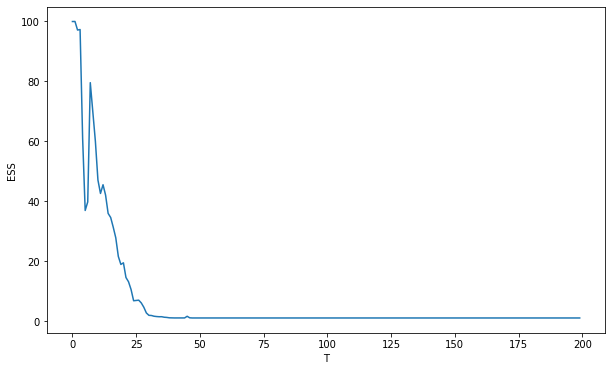

In [12]:
#ESS
plt.plot(np.arange(200), sis_ESS)
plt.xlabel('T')
plt.ylabel('ESS')
plt.show()

## 3.4 Sequential Importance Sampling with Resampling

Pick the same simulated trajectory as for the previous section.

**Q4:** Implement the **Sequential Importance Sampling with Resampling** or **Bootstrap Particle Filter** by completing the code below.

In [13]:
def bpf(model, y, numParticles):
    d = model.d
    n = len(y)
    N = numParticles
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:  # Initialize from prior
            particles[:, :, 0] = model.sample_state(N=N) 
        else:  # Resample and propagate according to dynamics
            ind = np.random.choice(N, N, replace=True, p=W[0, :, t-1])
            resampled_particles = particles[:, ind, (t-1)]
            particles[:, :, t] = model.sample_state(alpha0=resampled_particles, N=N) 

        # Compute weights
        logW[0, :, t] = model.log_lik(y[t], particles[:, :, t]) 
        W[0, :, t], logZ_now = exp_norm(logW[0, :, t])
        logZ +=  logZ_now # Update log-likelihood estimate
        N_eff[t] = ESS(W[0,:,t]) 

        # Compute filter estimates
        alpha_filt[:, 0, t] = particles[:, :, t] @ W[0, :, t] 
        
    return smc_res(alpha_filt, particles, W, N_eff = N_eff, logZ = logZ)

**Q5:** Use the same simulated trajectory as above and run the BPF algorithm using $N = 100$ particles. Show plots comparing the filter means from the Bootstrap Particle Filter algorithm with the underlying truth of the Infected, Exposed and Recovered. Also show a plot of how the ESS behaves over the run. Compare this with the results from the SIS algorithm.

In [14]:
bpf_alphas = bpf(model, y[0, 0,:], 100).alpha_filt
bpf_ESS = bpf(model, y[0, 0,:], 100).N_eff
bpf_W = bpf(model, y[0, 0,:], 100).W

In [15]:
bpf_W.shape


(1, 100, 200)

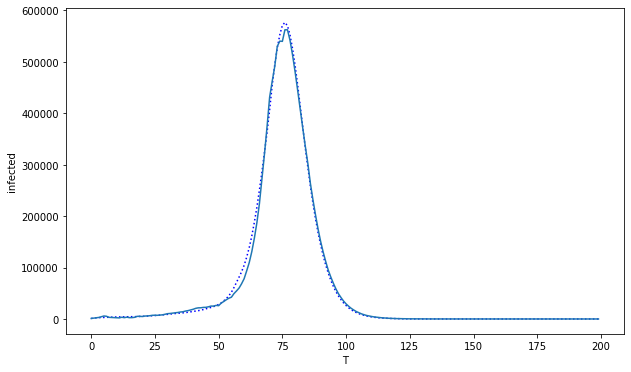

In [16]:
# infected 

plt.plot(np.arange(200),alpha[2,0,:], "b:")
plt.plot(np.arange(200),bpf_alphas[2,0,:])
plt.xlabel('T')
plt.ylabel('infected')
plt.show()

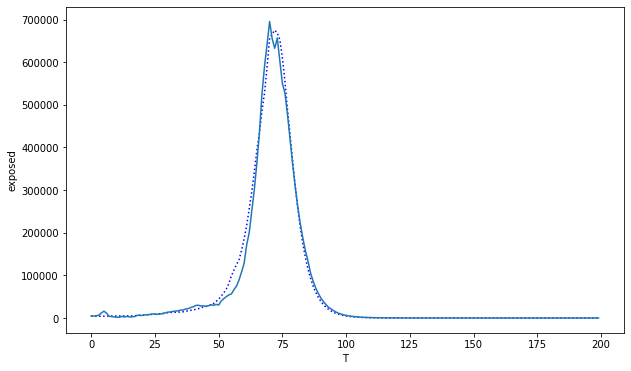

In [17]:
# exposed

plt.plot(np.arange(200),alpha[1,0,:], "b:")
plt.plot(np.arange(200),bpf_alphas[1,0,:])
plt.xlabel('T')
plt.ylabel('exposed')
plt.show()

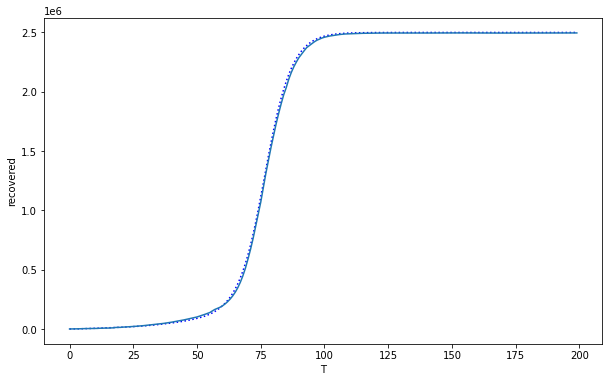

In [18]:
# recovered
R_sample = population_size - alpha[0,0,:] - alpha[1,0,:] - alpha[2,0,:] 
R_filter = population_size - bpf_alphas[0,0,:] - bpf_alphas[1,0,:] - bpf_alphas[2,0,:] 
plt.plot(np.arange(200), R_sample, "b:")
plt.plot(np.arange(200), R_filter)
plt.xlabel('T')
plt.ylabel('recovered')
plt.show()

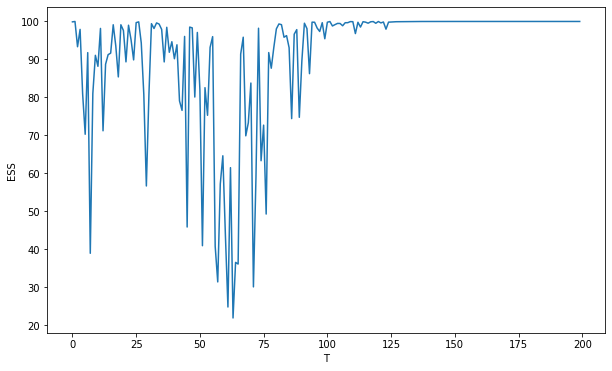

In [19]:
#ESS
plt.plot(np.arange(200), bpf_ESS)
plt.xlabel('T')
plt.ylabel('ESS')
plt.show()

# adaptive particle filter 

In [23]:
def ESSpf(model, y, numParticles, N_ef):
    d = model.d
    n = len(y)
    N = numParticles
    
    # Allocate memory
    particles = np.zeros((d, N, n), dtype = float)  # All generated particles
    logW = np.zeros((1, N, n))  # Unnormalized log-weight
    W = np.zeros((1, N, n))  # Normalized weight
    alpha_filt = np.zeros((d, 1, n))  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:  # Initialize from prior
            particles[:, :, 0] = model.sample_state(N=N) 
        else:  # Resample and propagate according to dynamics
            if N_eff[t-1] < N_ef:
                ind = np.random.choice(N, N, replace=True, p=W[0, :, t-1])
                particles[:, :, (t-1)] = particles[:, ind, (t-1)]
                W[0, :, t-1] = 1/N
            particles[:, :, t] = model.sample_state(alpha0=particles[:, :, (t-1)], N=N)
        # Compute weights
        logW[0, :, t] = model.log_lik(y[t], particles[:, :, t]) + logW[0, :, t]
        W[0, :, t], logZ_now = exp_norm(logW[0, :, t])
        logZ +=  logZ_now # Update log-likelihood estimate
        N_eff[t] = ESS(W[0,:,t]) 

        # Compute filter estimates
        alpha_filt[:, 0, t] = particles[:, :, t] @ W[0, :, t] 
        
    return smc_res(alpha_filt, particles, W, N_eff = N_eff, logZ = logZ)

In [39]:
ESSpf_alphas = ESSpf(model, y[0, 0,:], 100, 60).alpha_filt
ESSpf_ESS = ESSpf(model, y[0, 0,:], 100, 60).N_eff
ESSpf_W = ESSpf(model, y[0, 0,:], 100, 60).W

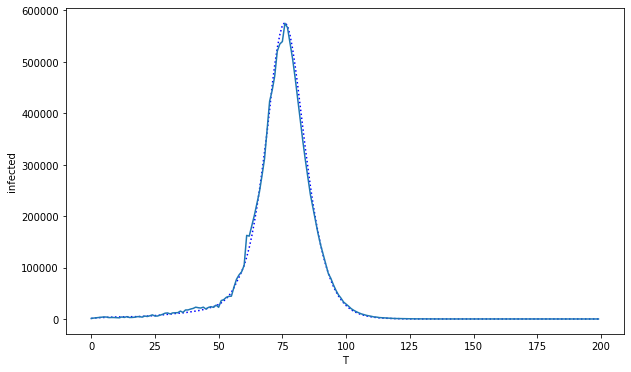

In [40]:
# infected 

plt.plot(np.arange(200),alpha[2,0,:], "b:")
plt.plot(np.arange(200),ESSpf_alphas[2,0,:])
plt.xlabel('T')
plt.ylabel('infected')
plt.show()

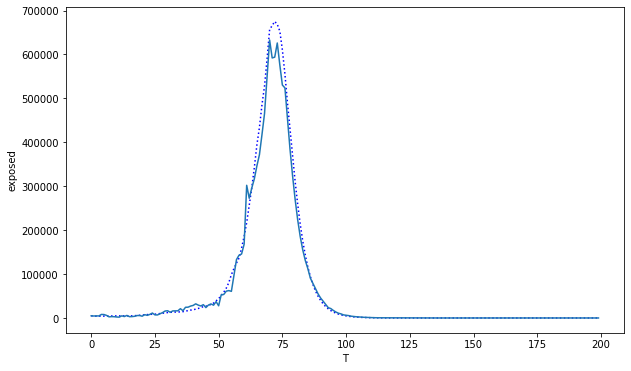

In [41]:
# exposed

plt.plot(np.arange(200),alpha[1,0,:], "b:")
plt.plot(np.arange(200),ESSpf_alphas[1,0,:])
plt.xlabel('T')
plt.ylabel('exposed')
plt.show()

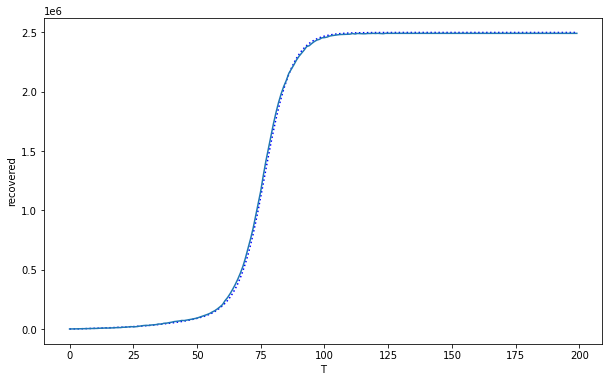

In [42]:
# recovered
R_sample = population_size - alpha[0,0,:] - alpha[1,0,:] - alpha[2,0,:] 
R_filter = population_size - ESSpf_alphas[0,0,:] - ESSpf_alphas[1,0,:] - ESSpf_alphas[2,0,:] 
plt.plot(np.arange(200), R_sample, "b:")
plt.plot(np.arange(200), R_filter)
plt.xlabel('T')
plt.ylabel('recovered')
plt.show()

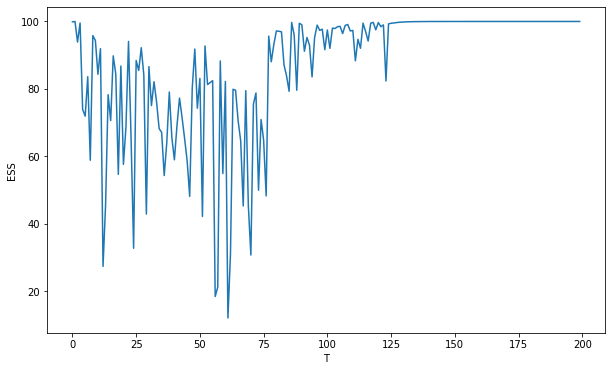

In [43]:
#ESS
plt.plot(np.arange(200), ESSpf_ESS)
plt.xlabel('T')
plt.ylabel('ESS')
plt.show()

## 3.5 Estimating the data likelihood and learning a model parameter
In this section we consider the real data and learning the model using this data. For simplicity we will only look at the problem of estimating the $\rho$ parameter and assume that others are fixed.

You are more than welcome to also study the other parameters.

Before we begin to tweak the parameters we run  the particle filter using the current parameter values to get a benchmark on the log-likelihood.

**Q6:** Run the bootstrap particle filter using $N=200$ particles on the real dataset and calculate the log-likelihood. Rerun the algorithm 20 times and show a box-plot of the log-likelihood.

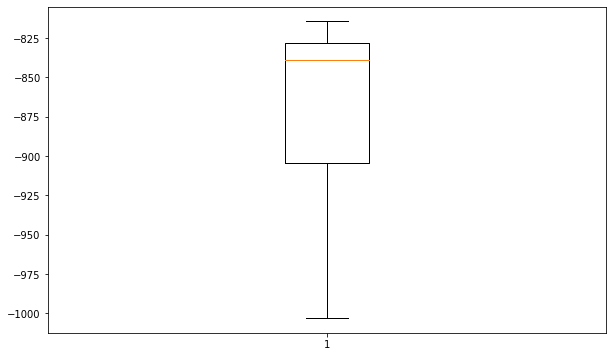

In [18]:
plt.boxplot([bpf(model, y_sthlm, 200).logZ for i in range(20)])
plt.show()

**Q7:** Make a grid of the $\rho$ parameter in the interval $[0.1, 0.9]$. Use the bootstrap particle filter to calculate the log-likelihood for each value. Run the bootstrap particle filter using $N=1000$ multiple times (at least 20) per value and use the average as your estimate of the log-likelihood. Plot the log-likelihood function and mark the maximal value.

*(hint: use np.linspace to create a grid of parameter values)*

In [19]:
rho_array = np.linspace(0.1,0.9 ,10)
loglikelihood_arr = np.zeros(len(rho_array))
for i in range(len(rho_array)):
    print(i)
    params = Param(pse, pei, pir, pic, rho_array[i], sigma_epsilon, init_mean, population_size)
    model = SEIR(params)
    loglikelihood_arr[i] = np.mean([bpf(model, y_sthlm, 1000).logZ for i in range(20)])

0
1
2
3
4
5
6
7
8
9


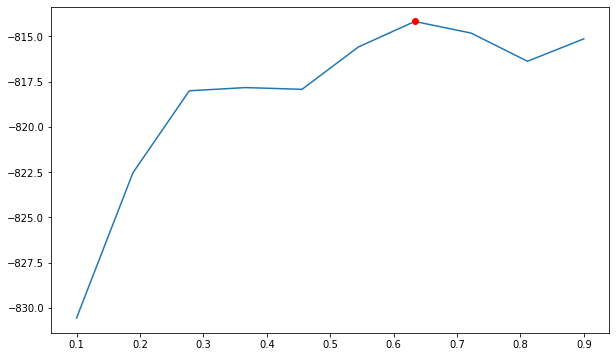

In [20]:
plt.plot(rho_array, loglikelihood_arr)
ymax = loglikelihood_arr.max()
xmax = rho_array[np.argmax(loglikelihood_arr)]
plt.plot(xmax,ymax, "ro")
plt.show()

**Q8:** Run the bootstrap particle filter on the full dataset with the optimal $\rho$ value. Present a plot of the estimated Infected, Exposed and Recovered states.

In [21]:
params = Param(pse, pei, pir, pic, xmax, sigma_epsilon, init_mean, population_size)
model = SEIR(params)

In [22]:
bpf_alphas = bpf(model, y_sthlm, 1000).alpha_filt

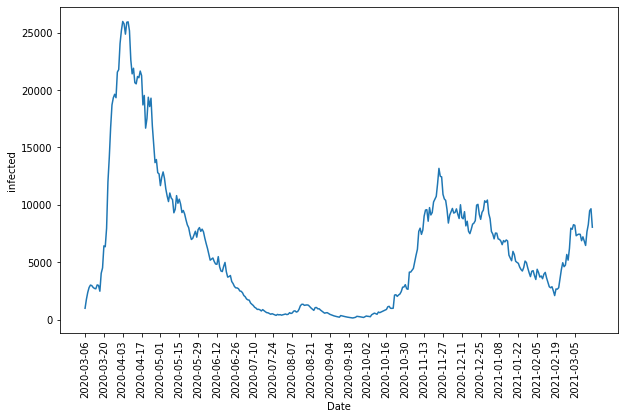

In [23]:
# infected 

plt.plot(np.arange(len(y_sthlm)),bpf_alphas[2,0,:])
plt.xticks(range(0, ndata, 14), u_sthlm[::14], rotation = 90)  # Show only one tick per 2 week for clarity
plt.xlabel('Date')
plt.ylabel('infected')
plt.show()

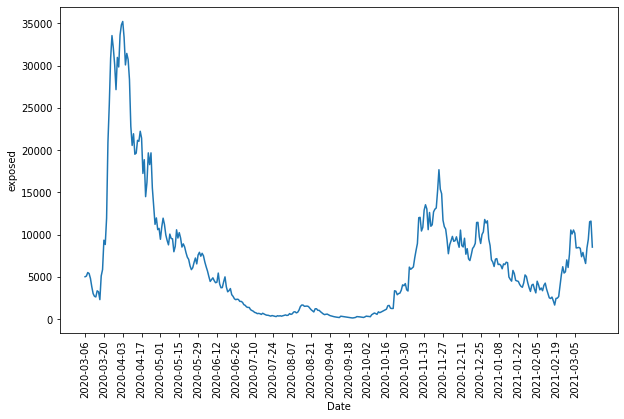

In [24]:
# exposed

plt.plot(np.arange(len(y_sthlm)),bpf_alphas[1,0,:])
plt.xticks(range(0, ndata, 14), u_sthlm[::14], rotation = 90)  # Show only one tick per 2 week for clarity
plt.xlabel('Date')
plt.ylabel('exposed')
plt.show()

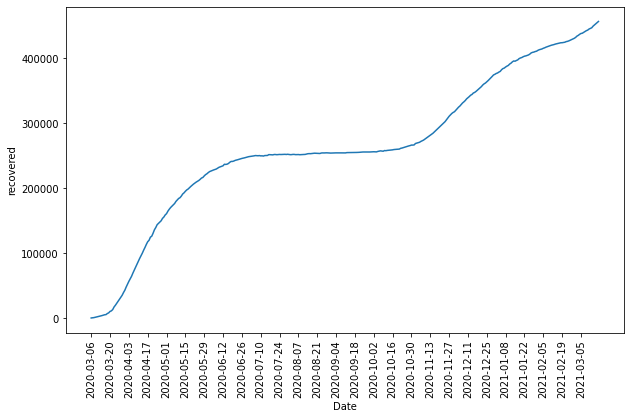

In [25]:
# recovered
R_filter = population_size - bpf_alphas[0,0,:] - bpf_alphas[1,0,:] - bpf_alphas[2,0,:] 
plt.plot(np.arange(len(y_sthlm)), R_filter)
plt.xticks(range(0, ndata, 14), u_sthlm[::14], rotation = 90)  # Show only one tick per 2 week for clarity
plt.xlabel('Date')
plt.ylabel('recovered')
plt.show()